Github Link: https://github.com/dreeew05/CMSC-197/tree/main/Assignment%203

In [352]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Regex for removing unwanted characters
import re

# To read email
from email import policy
from email.parser import BytesParser

# To count common words
from collections import Counter

Define Constants

In [353]:
FOLDER_PATH = "trec06p-cs280/"

Import the stop words and convert into array

In [354]:
stop_words = open('stop_words.txt').read().splitlines()

# For visualization purposes
stop_words[:5]

['a', 'able', 'about', 'above', 'abst']

Initial DataFrame

In [355]:
data = {
    'file_path': [],
    'category': []
}
df = pd.DataFrame(data)

$\textbf{Preprocessing}$

In [356]:
labels_path = f"{FOLDER_PATH}labels"
with open(labels_path) as f:
    # Remove ../to mitigate file access errors
    str_to_remove = "../"
    for line in f:
        category, path = line.split()
        clean_path = path.replace(str_to_remove, '')
        new_row = pd.DataFrame([[clean_path, category]], columns=["file_path", "category"])
        df = pd.concat([df, new_row], ignore_index=True)

df

,file_path,category
0,data/000/000,ham
1,data/000/001,spam
2,data/000/002,spam
3,data/000/003,ham
4,data/000/004,spam
...,...,...
37817,data/126/017,spam
37818,data/126/018,spam
37819,data/126/019,spam
37820,data/126/020,spam


Cleaning the email:

- Remove alphanumeric characters
- Remove punctuation marks
- Remove stop words

In [357]:
def clean_email(email_body):
    # [^a-zA-Z\s]+ => For non-alphabetic and non-whitespace (punctuations, new line, tab)
    # \s+ => For one or more whitespace characters
    pattern = r"[^a-zA-Z\s]+|\s+"  # Combine both patterns
    return re.sub(pattern, " ", email_body).strip().lower()

    # Split and remove stop words in a single step
    # return [word for word in clean_message.split() if word not in stop_words]

In [358]:
def remove_stop_words(clean_message):
    return [word for word in clean_message.split() if word not in stop_words]

Iterating to each mail:
- Clean each mail
- Tokenize the clean mail

In [359]:
def tokenize_mail(df, to_remove_stop_words = False):
    contents_arr = []

    for path in df["file_path"]:
        current_file_path = f"{FOLDER_PATH}{path}"
        with open(current_file_path, "rb") as f:
            raw_email = f.read()

        # Parse email content
        msg = BytesParser(policy=policy.default).parsebytes(raw_email)

        # Extract body (defaulting to empty string in case of issues)
        body = ""

        # Define a function to decode email parts safely
        def decode_payload(part):
            try:
                charset = part.get_content_charset() or "utf-8"
                return part.get_payload(decode=True).decode(charset)
            except (LookupError, UnicodeDecodeError):
                return part.get_payload(decode=True).decode("utf-8", errors="replace")

        # Check for multipart or single-part message
        if msg.is_multipart():
            for part in msg.iter_parts():
                if part.get_content_type() == "text/plain":
                    body = decode_payload(part)
                    break
        else:
            body = decode_payload(msg)

        # Clean the email body and append the word list
        # word_list = clean_email(body)
        clean_email_body = clean_email(body)
        if to_remove_stop_words:
            word_list= remove_stop_words(clean_email_body)
        else:
            word_list = list(clean_email_body.split())
        contents_arr.append(word_list)
    return contents_arr

Adding another column to dataframe

In [360]:
df['word_list'] = tokenize_mail(df, True)

Split the dataset into three groups:

- Training set for ham
- Training set for spam
- Testing set

In [361]:
def split_dataset(df):
    train_df = df[df["file_path"] < "data/071"]
    train_ham_df = train_df[train_df["category"] == "ham"]
    train_spam_df = train_df[train_df["category"] == "spam"]

    test_df = df[df["file_path"] >= "data/071"]

    return train_df, train_ham_df, train_spam_df, test_df

In [362]:
# For Visualization Purposes
train_df, train_ham_df, train_spam_df, test_df = split_dataset(df)
print("Training Set")
display(train_df)
print("Ham Training Set")
display(train_ham_df)
print("Spam Training Set")
display(train_spam_df)
print("Testing Set")
display(test_df)

Training Set


,file_path,category,word_list
0,data/000/000,ham,"[mailing, list, queried, weeks, ago, running, ..."
1,data/000/001,spam,"[luxury, watches, buy, rolex, rolex, cartier, ..."
2,data/000/002,spam,"[academic, qualifications, prestigious, acc, r..."
3,data/000/003,ham,"[greetings, verify, subscription, plan, fans, ..."
4,data/000/004,spam,"[chauncey, conferred, luscious, continued, ton..."
...,...,...,...
21295,data/070/295,spam,"[http, high, biz, ez, xin, walla]"
21296,data/070/296,spam,"[special, offer, adobe, video, collection, ado..."
21297,data/070/297,spam,"[doctype, html, public, dtd, html, transitiona..."
21298,data/070/298,ham,"[mounted, infrared, demodulator, hb, realised,..."


Ham Training Set


,file_path,category,word_list
0,data/000/000,ham,"[mailing, list, queried, weeks, ago, running, ..."
3,data/000/003,ham,"[greetings, verify, subscription, plan, fans, ..."
5,data/000/005,ham,"[quiet, quiet, well, straw, poll, plan, running]"
6,data/000/006,ham,"[working, departed, totally, bell, labs, recom..."
10,data/000/010,ham,"[greetings, mass, acknowledgement, signed, pla..."
...,...,...,...
21270,data/070/270,ham,"[equation, generate, prime, numbers, equation,..."
21271,data/070/271,ham,"[equation, generate, prime, numbers, equation,..."
21288,data/070/288,ham,"[dear, dmdx, users, guidance, generating, dmdx..."
21293,data/070/293,ham,"[built, handyboard, works, great, testmotor, p..."


Spam Training Set


,file_path,category,word_list
1,data/000/001,spam,"[luxury, watches, buy, rolex, rolex, cartier, ..."
2,data/000/002,spam,"[academic, qualifications, prestigious, acc, r..."
4,data/000/004,spam,"[chauncey, conferred, luscious, continued, ton..."
7,data/000/007,spam,"[nbc, today, body, diet, beaches, magazines, h..."
8,data/000/008,spam,"[oil, sector, going, crazy, weekly, gift, kkpt..."
...,...,...,...
21294,data/070/294,spam,"[txt, add]"
21295,data/070/295,spam,"[http, high, biz, ez, xin, walla]"
21296,data/070/296,spam,"[special, offer, adobe, video, collection, ado..."
21297,data/070/297,spam,"[doctype, html, public, dtd, html, transitiona..."


Testing Set


,file_path,category,word_list
21300,data/071/000,spam,"[hesitantly, derive, perverse, satisfaction, c..."
21301,data/071/001,ham,"[things, perform, experiment, display, will, r..."
21302,data/071/002,spam,"[best, offer, month, viggra, ci, ialis, vaiium..."
21303,data/071/003,spam,"[de, ar, wne, cr, doesn, matter, ow, real, st,..."
21304,data/071/004,spam,"[special, offer, adobe, video, collection, ado..."
...,...,...,...
37817,data/126/017,spam,"[great, news, expec, ted, infinex, ventures, i..."
37818,data/126/018,spam,"[oil, sector, going, crazy, weekly, gift, kkpt..."
37819,data/126/019,spam,"[http, vdtobj, docscan, info, suffering, pain,..."
37820,data/126/020,spam,"[prosperous, future, increased, money, earning..."


Get the 10000 most common words from the training set

In [363]:
def get_top_words(train_df):
    training_words = [word for sublist in train_df["word_list"] for word in sublist]

    word_count = Counter(training_words)
    top_common_words_with_freq = word_count.most_common(COMMON_WORD_COUNT)
    common_words = [word for word, _ in top_common_words_with_freq]

    return top_common_words_with_freq, common_words

In [364]:
top_common_words_with_freq, common_words = get_top_words(train_df)

# For vizualization purposes
top_common_words_with_freq[:10]

[('http', 27587),
 ('font', 27472),
 ('td', 27416),
 ('br', 24631),
 ('width', 13978),
 ('tr', 12527),
 ('will', 11484),
 ('size', 11289),
 ('color', 7526),
 ('html', 7319)]

$\textbf{Creating the feature matrices}$

In [365]:
def create_feature_matrix(emails, common_words):
    emails_num = len(emails)
    count = len(common_words)
    # Initialize with zeros
    feature_matrix = np.zeros((emails_num, count), dtype=int)

    for i, email in enumerate(emails):
        for word in email:
            if word in common_words:
                index = common_words.index(word)
                feature_matrix[i, index] += 1
    return feature_matrix

In [366]:
ham_fm = create_feature_matrix(train_ham_df['word_list'], common_words)
print(f'Ham Matrix: \n {ham_fm}\n')

spam_fm = create_feature_matrix(train_spam_df['word_list'], common_words)
print(f"Spam Matrix: \n {spam_fm}")

Ham Matrix: 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Spam Matrix: 
 [[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [6 4 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]]


$\textbf{Computing the priors}$

$$P(c = \text{ham}) = \frac{N_{\text{ham}}}{N_{\text{doc}}}$$
$$P(c = \text{spam}) = \frac{N_{\text{spam}}}{N_{\text{doc}}}$$


In [367]:
def compute_priors(train_df, train_ham_df, train_spam_df):
    n_ham = train_ham_df.shape[0]       # Number of ham emails in training set
    n_spam = train_spam_df.shape[0]     # Number of spam emails in training set
    n_doc = train_df.shape[0]           # Number of total emails in training set

    p_ham = n_ham / n_doc
    p_spam = n_spam / n_doc
    return p_ham, p_spam

In [368]:
p_ham, p_spam = compute_priors(train_df, train_ham_df, train_spam_df)
print(f"P_ham: {p_ham} | P_spam: {p_spam}")

P_ham: 0.3531924882629108 | P_spam: 0.6468075117370892


$\textbf{Computing the likelihood of each word}$

$$P(w_i | \text{spam}) = \frac{\text{count}(w_i, \text{spam}) + \lambda}{\left( \sum_{w \in V} \text{count}(w, \text{spam}) \right) + \lambda |V|}$$

$$P(w_i | \text{ham}) = \frac{\text{count}(w_i, \text{ham}) + \lambda}{\left( \sum_{w \in V} \text{count}(w, \text{ham}) \right) + \lambda |V|}$$

In [369]:
def compute_likelihood(ham_fm, spam_fm, common_words, lmbda=1):
    # Vectorized sum of word counts in ham and spam
    ham_word_count = np.sum(ham_fm, axis=0)
    spam_word_count = np.sum(spam_fm, axis=0)

    # Calculate total word counts for ham and spam
    ham_word_total = np.sum(ham_word_count)
    spam_word_total = np.sum(spam_word_count)

    # Initialize dictionaries for probabilities of each word in ham and spam classes
    p_ham_count = {}
    p_spam_count = {}

    count = len(common_words)

    # Calculate probabilities with Laplace smoothing
    for i in range(count):
        curr_ham_word = (ham_word_count[i] + lmbda) / (ham_word_total + lmbda * count)
        curr_spam_word = (spam_word_count[i] + lmbda) / (
            spam_word_total + lmbda * count
        )
        p_ham_count[common_words[i]] = curr_ham_word
        p_spam_count[common_words[i]] = curr_spam_word

    return p_ham_count, p_spam_count

In [370]:
p_ham_count, p_spam_count = compute_likelihood(ham_fm, spam_fm, common_words)

$\textbf{Classifying the emails}$
$$\log \left( P(c \mid w_d) \right) = \sum_{i=1}^{d} \log \left( w_i \mid c \right) + \log \left( P(c) \right)
$$

- Returns the prediction (spam or ham)

In [371]:
def classify_emails(
    tokenized_email, p_ham, p_spam, p_ham_count, p_spam_count, common_words
):
    # Initialize log values of ham and spam with their prior probabilities
    log_p_ham = np.log(p_ham)
    log_p_spam = np.log(p_spam)

    # Iterate each tokenized words in the email's body and
    # only process words that are in the top 1000 words
    for w in tokenized_email:
        if w in common_words:
            log_p_ham += np.log(p_ham_count[w])
            log_p_spam += np.log(p_spam_count[w])

    return "ham" if log_p_ham > log_p_spam else "spam"

$\textbf{Testing the Classifier}$

In [372]:
def test_classifier(
    test_df, p_ham, p_spam, p_ham_count, p_spam_count, common_words
):
    prediction = []
    # Loop through the emails in test_df
    for tokenized_email in test_df["word_list"]:
        category = classify_emails(
            tokenized_email, p_ham, p_spam, p_ham_count, p_spam_count, common_words
        )  
        prediction.append(category)
    return prediction

In [373]:
test_df = test_df.copy()

test_df.loc[:, "prediction"] = test_classifier(
    test_df, p_ham, p_spam, p_ham_count, p_spam_count, common_words
)

test_df

,file_path,category,word_list,prediction
21300,data/071/000,spam,"[hesitantly, derive, perverse, satisfaction, c...",spam
21301,data/071/001,ham,"[things, perform, experiment, display, will, r...",ham
21302,data/071/002,spam,"[best, offer, month, viggra, ci, ialis, vaiium...",spam
21303,data/071/003,spam,"[de, ar, wne, cr, doesn, matter, ow, real, st,...",spam
21304,data/071/004,spam,"[special, offer, adobe, video, collection, ado...",spam
...,...,...,...,...
37817,data/126/017,spam,"[great, news, expec, ted, infinex, ventures, i...",spam
37818,data/126/018,spam,"[oil, sector, going, crazy, weekly, gift, kkpt...",spam
37819,data/126/019,spam,"[http, vdtobj, docscan, info, suffering, pain,...",spam
37820,data/126/020,spam,"[prosperous, future, increased, money, earning...",spam


$\textbf{Performance Evaluation}$

In [374]:
def evaluate_performance(test_df):
    y_true = test_df["category"]
    y_pred = test_df["prediction"]

    tp = ((y_true == "spam") & (y_pred == "spam")).sum()
    tn = ((y_true == "ham") & (y_pred == "ham")).sum()
    fp = ((y_true == "ham") & (y_pred == "spam")).sum()
    fn = ((y_true == "spam") & (y_pred == "ham")).sum()

    accuracy = (tn + tp) / (tn + tp + fp + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)

    return accuracy, recall, precision

In [375]:
accuracy, recall, precision = evaluate_performance(test_df)
print(f"Accuracy: {accuracy}\nRecall: {recall}\nPrecision: {precision}")

Accuracy: 0.9196223217528144
Recall: 0.9163897620116749
Precision: 0.9625507027638902


$\textbf{Results and Discussions}$

1. What is the effect of removing stop words in terms of precision, recall, and accuracy? Show a plot or a table of these results.

- Call the functions again and run without stop words

In [376]:
df_wo_stop = df.copy()
df_wo_stop['word_list'] = tokenize_mail(df_wo_stop, False)
train_df_wo_stop, train_ham_df_wo_stop, train_spam_df_wo_stop, test_df_wo_stop = (
    split_dataset(df_wo_stop)
)

Top common words without removing stop words

In [377]:
top_common_words_with_freq_wo_stop, common_words_wo_stop = get_top_words(
    train_df_wo_stop
)

# For vizualization purposes
top_common_words_with_freq_wo_stop[:10]

[('the', 132456),
 ('a', 101655),
 ('to', 84414),
 ('and', 64342),
 ('i', 59997),
 ('of', 57634),
 ('in', 44268),
 ('is', 36561),
 ('b', 31967),
 ('you', 31784)]

In [378]:
ham_fm_wo_stop = create_feature_matrix(train_ham_df_wo_stop["word_list"], common_words_wo_stop)
spam_fm_wo_stop = create_feature_matrix(train_spam_df_wo_stop["word_list"], common_words_wo_stop)

p_ham_wo_stop, p_spam_wo_stop = compute_priors(train_df_wo_stop, train_ham_df_wo_stop, train_spam_df_wo_stop)
p_ham_count_wo_stop, p_spam_count_wo_stop = compute_likelihood(
    ham_fm_wo_stop, spam_fm_wo_stop, common_words_wo_stop
)

In [379]:
test_df_wo_stop.loc[:, "prediction"] = test_classifier(
    test_df_wo_stop,
    p_ham_wo_stop,
    p_spam_wo_stop,
    p_ham_count_wo_stop,
    p_spam_count_wo_stop,
    common_words_wo_stop,
)
test_df_wo_stop

C:\Users\glena\AppData\Local\Temp\ipykernel_19032\2239841836.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_wo_stop.loc[:, "prediction"] = test_classifier(


,file_path,category,word_list,prediction
21300,data/071/000,spam,"[where, we, can, hesitantly, derive, perverse,...",spam
21301,data/071/001,ham,"[there, are, several, things, you, can, use, t...",ham
21302,data/071/002,spam,"[best, offer, of, the, month, viggra, ci, iali...",spam
21303,data/071/003,spam,"[de, i, ar, home, o, h, wne, n, r, your, cr, v...",spam
21304,data/071/004,spam,"[special, offer, adobe, video, collection, ado...",spam
...,...,...,...,...
37817,data/126/017,spam,"[great, news, expec, ted, infinex, ventures, i...",spam
37818,data/126/018,spam,"[the, oil, sector, is, going, crazy, this, is,...",spam
37819,data/126/019,spam,"[http, vdtobj, docscan, info, suffering, from,...",spam
37820,data/126/020,spam,"[u, n, i, v, e, r, s, i, t, y, d, i, p, l, o, ...",spam


In [380]:
accuracy_wo_stop, recall_wo_stop, precision_wo_stop = evaluate_performance(
    test_df_wo_stop
)

Compare both scores using plot

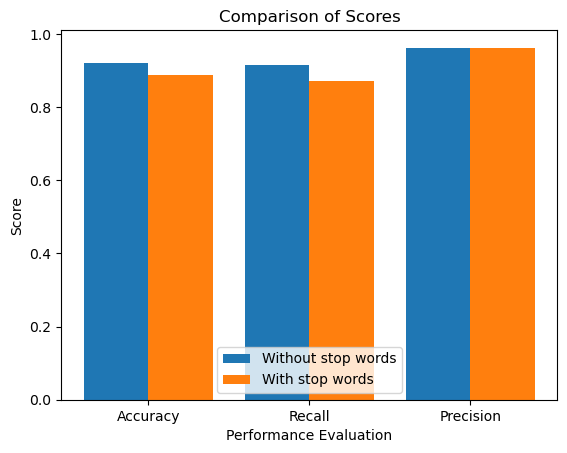

Without stop words:
Accuracy: 0.9196223217528144
Recall: 0.9163897620116749
Precision: 0.9625507027638902

With stop words:
Accuracy: 0.8890570148892386
Recall: 0.8704984283789852
Precision: 0.9612257040856803



In [381]:
titles = ['Accuracy', 'Recall', 'Precision']
score = [accuracy, recall, precision]
score_wo_stop = [accuracy_wo_stop, recall_wo_stop, precision_wo_stop]

X_axis = np.arange(len(titles))
plt.bar(X_axis - 0.2, score, 0.4, label="Without stop words")
plt.bar(X_axis + 0.2, score_wo_stop, 0.4, label="With stop words")

plt.xticks(X_axis, titles)
plt.xlabel("Performance Evaluation")
plt.ylabel("Score")
plt.title("Comparison of Scores")
plt.legend()
plt.show()

print("Without stop words:")
print(f"Accuracy: {accuracy}\nRecall: {recall}\nPrecision: {precision}\n")

print("With stop words:")
print(f"Accuracy: {accuracy_wo_stop}\nRecall: {recall_wo_stop}\nPrecision: {precision_wo_stop}\n")

Conclusion:

Due to the removal of the stop words, all measures of performance evaluation is higher than without removing the said words. In this case, the difference does not exceed 5%, with recall (approx. 4.56%) being the most affected, followed by accuracy (approx. 3.06%), then precision (approx. 0.01%). Thus, removing these nuisance improves the model's performance.

2. Experiment on the number of words used for training. Filter the dictionary to
include only words occurring more than k times (1000 words, then k > 100, and k
= 50 times). For example, the word “offer” appears 150 times, that means that it
will be included in the dictionary.

Search for words that appear onlt 50 times (k=50)

In [382]:
k_50_filtered_data = [entry for entry in top_common_words_with_freq if entry[1] == 50]
k_50_words = [entry[0] for entry in k_50_filtered_data]

Copy the original splitted data

In [383]:
train_ham_df_k50 = train_ham_df.copy()
train_spam_df_k50 = train_spam_df.copy()
test_df_k50 = test_df.copy()

In [384]:
ham_fm_k50 = create_feature_matrix(train_ham_df_k50["word_list"], k_50_words)
spam_fm_k50 = create_feature_matrix(train_spam_df_k50["word_list"], k_50_words)

p_ham_k50, p_spam_k50 = compute_priors(train_df, train_ham_df, train_spam_df)
p_ham_count_k50, p_spam_count_k50 = compute_likelihood(
    ham_fm_k50, spam_fm_k50, k_50_words
)

test_df_k50 = test_df.copy()

test_df_k50.loc[:, "prediction"] = test_classifier(
    test_df,
    p_ham_k50,
    p_spam_k50,
    p_ham_count_k50,
    p_spam_count_k50,
    k_50_words,
)

accuracy_k_50, recall_k_50, precision_k_50 = evaluate_performance(test_df)
print(
    f"Accuracy: {accuracy_k_50}\nRecall: {recall_k_50}\nPrecision: {precision_k_50}\n"
)